In [407]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import numpy.fft as fft
import cv2

In [408]:
#helper functions
def get_centered_dft(img):
    dft = np.fft.fft2(img)
    centered_dft = np.fft.fftshift(dft)
    return centered_dft

def restore_img_from_centered_dft(centered_dft):
    dft = np.fft.fftshift(centered_dft)
    img = np.fft.ifft2(dft)
    return img

def flat_transform(dft):
    real = dft.real
    imag = dft.imag
    H, W = dft.shape
    flat_dft = np.zeros((H, 2 * W))
    flat_dft[:, ::2] = real
    flat_dft[:, 1::2] = imag
    return flat_dft

def inverse_flat_transform(flat_dft):
    real = flat_dft[:, ::2]
    imag = flat_dft[:, 1::2]
    dft = np.vectorize(complex)(real, imag)
    return dft
    

def show_centered_dft(centered_dft):
    figures_dft_phase = np.angle(centered_dft)
    figures_dft_magnitude = np.abs(centered_dft)
    figures_dft_log_magnitude = np.log10(figures_dft_magnitude)

    phase_stretched = (figures_dft_phase - np.min(figures_dft_phase)) / (np.max(figures_dft_phase) - np.min(figures_dft_phase))
    log_magnitude_stretched = (figures_dft_log_magnitude - np.min(figures_dft_log_magnitude)) / (np.max(figures_dft_log_magnitude) - np.min(figures_dft_log_magnitude))

    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(phase_stretched, cmap='gray')
    axs[0].set_title('Phase Component')
    axs[1].imshow(log_magnitude_stretched, cmap='gray')
    axs[1].set_title('Logarithm of Magnitude Component')
    plt.show()

def center_transform(image):
    h, w = image.shape[:2]
    n = min(h * w, min(h, w) ** 2)
    center = (h - 1) // 2, (w - 1) // 2
    indices = [(i, j) for i in range(h) for j in range(w)]
    original_indices = [(i, j) for i in range(h) for j in range(w)]
    indices.sort(key=lambda x: (x[0] - center[0]) ** 2 + (x[1] - center[1]) ** 2)
    indices = indices[:n]
    new_image = np.zeros_like(image)
    for i in range(n):
        new_image[original_indices[i]] = image[indices[i]]
    return new_image

def inverse_center_transform(image):
    h, w = image.shape[:2]
    n = min(h * w, min(h, w) ** 2)
    center = (h - 1) // 2, (w - 1) // 2
    indices = [(i, j) for i in range(h) for j in range(w)]
    original_indices = [(i, j) for i in range(h) for j in range(w)]
    indices.sort(key=lambda x: (x[0] - center[0]) ** 2 + (x[1] - center[1]) ** 2)
    indices = indices[:n]
    new_image = np.zeros_like(image)
    for i in range(n):
        new_image[indices[i]] = image[original_indices[i]]
    return new_image

def DFT_transform(img):
    temp = get_centered_dft(img)
    temp = center_transform(temp)
    temp = flat_transform(temp)
    return temp

def inverse_DFT_transform(img):
    temp = inverse_flat_transform(img)
    temp = inverse_center_transform(temp)
    temp = restore_img_from_centered_dft(temp)
    return temp.real

In [409]:
## Standard libraries
import os
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
plt.set_cmap('cividis')
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats('svg', 'pdf') # For export
from matplotlib.colors import to_rgb
import seaborn as sns

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim
# Torchvision
import torchvision
from torchvision.datasets import MNIST
from torchvision import transforms
# PyTorch Lightning
import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Path to the folder where the datasets are/should be downloaded (e.g. MNIST)
DATASET_PATH = "../data"
# Path to the folder where the pretrained models are saved
CHECKPOINT_PATH = "../saved_models/tutorial12"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Fetching the device that will be used throughout this notebook
device = torch.device("cpu") if not torch.cuda.is_available() else torch.device("cuda:0")
print("Using device", device)

C:\Users\lenovo\AppData\Local\Temp\ipykernel_23792\960354683.py:11: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats('svg', 'pdf') # For export
Seed set to 42


Using device cpu


In [410]:
import urllib.request
from urllib.error import HTTPError
# Github URL where saved models are stored
base_url = "https://raw.githubusercontent.com/phlippe/saved_models/main/tutorial12/"
# Files to download
pretrained_files = ["PixelCNN.ckpt"]
# Create checkpoint path if it doesn't exist yet
os.makedirs(CHECKPOINT_PATH, exist_ok=True)

# For each file, check whether it already exists. If not, try downloading it.
for file_name in pretrained_files:
    file_path = os.path.join(CHECKPOINT_PATH, file_name)
    if not os.path.isfile(file_path):
        file_url = base_url + file_name
        print(f"Downloading {file_url}...")
        try:
            urllib.request.urlretrieve(file_url, file_path)
        except HTTPError as e:
            print("Something went wrong. Please try to download the file from the GDrive folder, or contact the author with the full output including the following error:\n", e)

In [411]:
from torch.utils.data import Subset

In [412]:
# Convert images from 0-1 to 0-255 (integers). We use the long datatype as we will use the images as labels as well
def discretize(sample):
    return (sample * 255).to(torch.long)

def print_shape(img):
    print(img.shape)
    return img

dft_lambda = lambda x: torch.from_numpy(np.array([DFT_transform(img) for img in x.numpy()])).to(torch.long)
max_log = 0
min_log = 0

def normalize(img):
    global max_log
    global min_log
    max_value = 27526
    # max_log = max(max_log, max_value)
    min_value = -18065
    # min_log = min(min_log, min_value)
    return ((img-min_value) * 255 / (max_value - min_value)).to(torch.long)

# Transformations applied on each image => only make them a tensor
transform = transforms.Compose([transforms.ToTensor(),
                                discretize,
                                transforms.Lambda(dft_lambda),
                                normalize
                                ])

# Loading the training dataset. We need to split it into a training and validation part
train_dataset = MNIST(root=DATASET_PATH, train=True, transform=transform, download=True)
pl.seed_everything(42)
train_set, val_set = torch.utils.data.random_split(train_dataset, [50000, 10000])

# Loading the test set
test_set = MNIST(root=DATASET_PATH, train=False, transform=transform, download=True)

#try to overfit on one image
train_set = Subset(train_dataset, [0])
val_set = Subset(train_dataset, [0])
test_set = Subset(train_dataset, [0])

# We define a set of data loaders that we can use for various purposes later.
# train_loader = data.DataLoader(train_set, batch_size=128, shuffle=True, drop_last=True, pin_memory=True, num_workers=0)
# val_loader = data.DataLoader(val_set, batch_size=128, shuffle=False, drop_last=False, num_workers=0)
# test_loader = data.DataLoader(test_set, batch_size=128, shuffle=False, drop_last=False, num_workers=0)

train_loader = data.DataLoader(train_set, batch_size=1, shuffle=True, drop_last=True, pin_memory=True, num_workers=0)
val_loader = data.DataLoader(val_set, batch_size=1, shuffle=False, drop_last=False, num_workers=0)
test_loader = data.DataLoader(test_set, batch_size=1, shuffle=False, drop_last=False, num_workers=0)

# train_max = torch.max(train_dataset.data)
# train_min = torch.min(train_dataset.data)
# test_max = torch.max(test_set.data)
# test_min = torch.min(test_set.data)
# data_max = max(train_max, test_max)
# data_min = min(train_min, test_min)
# print("max_value: ", data_max)
# print("min_value: ", data_min)


Seed set to 42


In [413]:
print(max_log)
print(min_log)

0
0


In [414]:
def show_imgs(imgs):
    num_imgs = imgs.shape[0] if isinstance(imgs, torch.Tensor) else len(imgs)
    nrow = min(num_imgs, 4)
    ncol = int(math.ceil(num_imgs/nrow))
    imgs = torchvision.utils.make_grid(imgs, nrow=nrow, pad_value=128)
    imgs = imgs.clamp(min=0, max=255)
    np_imgs = imgs.cpu().numpy()
    plt.figure(figsize=(1.5*nrow, 1.5*ncol))
    plt.imshow(np.transpose(np_imgs, (1,2,0)), interpolation='nearest')
    plt.axis('off')
    plt.show()
    plt.close()

# show_imgs([train_set[i][0] for i in range(8)])

In [415]:
class MaskedConvolution(nn.Module):

    def __init__(self, c_in, c_out, mask, **kwargs):
        """
        Implements a convolution with mask applied on its weights.
        Inputs:
            c_in - Number of input channels
            c_out - Number of output channels
            mask - Tensor of shape [kernel_size_H, kernel_size_W] with 0s where
                   the convolution should be masked, and 1s otherwise.
            kwargs - Additional arguments for the convolution
        """
        super().__init__()
        # For simplicity: calculate padding automatically
        kernel_size = (mask.shape[0], mask.shape[1])
        dilation = 1 if "dilation" not in kwargs else kwargs["dilation"]
        padding = tuple([dilation*(kernel_size[i]-1)//2 for i in range(2)])
        # Actual convolution
        self.conv = nn.Conv2d(c_in, c_out, kernel_size, padding=padding, **kwargs)

        # Mask as buffer => it is no parameter but still a tensor of the module
        # (must be moved with the devices)
        self.register_buffer('mask', mask[None,None])

    def forward(self, x):
        self.conv.weight.data *= self.mask # Ensures zero's at masked positions
        return self.conv(x)

In [416]:
class VerticalStackConvolution(MaskedConvolution):

    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        # Mask out all pixels below. For efficiency, we could also reduce the kernel
        # size in height, but for simplicity, we stick with masking here.
        mask = torch.ones(kernel_size, kernel_size)
        mask[kernel_size//2+1:,:] = 0

        # For the very first convolution, we will also mask the center row
        if mask_center:
            mask[kernel_size//2,:] = 0

        super().__init__(c_in, c_out, mask, **kwargs)

class HorizontalStackConvolution(MaskedConvolution):

    def __init__(self, c_in, c_out, kernel_size=3, mask_center=False, **kwargs):
        # Mask out all pixels on the left. Note that our kernel has a size of 1
        # in height because we only look at the pixel in the same row.
        mask = torch.ones(1,kernel_size)
        mask[0,kernel_size//2+1:] = 0

        # For the very first convolution, we will also mask the center pixel
        if mask_center:
            mask[0,kernel_size//2] = 0

        super().__init__(c_in, c_out, mask, **kwargs)

In [417]:
class GatedMaskedConv(nn.Module):

    def __init__(self, c_in, **kwargs):
        """
        Gated Convolution block implemented the computation graph shown above.
        """
        super().__init__()
        self.conv_vert = VerticalStackConvolution(c_in, c_out=2*c_in, **kwargs)
        self.conv_horiz = HorizontalStackConvolution(c_in, c_out=2*c_in, **kwargs)
        self.conv_vert_to_horiz = nn.Conv2d(2*c_in, 2*c_in, kernel_size=1, padding=0)
        self.conv_horiz_1x1 = nn.Conv2d(c_in, c_in, kernel_size=1, padding=0)

    def forward(self, v_stack, h_stack):
        # Vertical stack (left)
        v_stack_feat = self.conv_vert(v_stack)
        v_val, v_gate = v_stack_feat.chunk(2, dim=1)
        v_stack_out = torch.tanh(v_val) * torch.sigmoid(v_gate)

        # Horizontal stack (right)
        h_stack_feat = self.conv_horiz(h_stack)
        h_stack_feat = h_stack_feat + self.conv_vert_to_horiz(v_stack_feat)
        h_val, h_gate = h_stack_feat.chunk(2, dim=1)
        h_stack_feat = torch.tanh(h_val) * torch.sigmoid(h_gate)
        h_stack_out = self.conv_horiz_1x1(h_stack_feat)
        h_stack_out = h_stack_out + h_stack

        return v_stack_out, h_stack_out

In [418]:
val_losses_log = []
train_losses_log = []

In [419]:
class PixelCNN(pl.LightningModule):

    def __init__(self, c_in, c_hidden):
        super().__init__()
        self.save_hyperparameters()

        # Initial convolutions skipping the center pixel
        self.conv_vstack = VerticalStackConvolution(c_in, c_hidden, mask_center=True)
        self.conv_hstack = HorizontalStackConvolution(c_in, c_hidden, mask_center=True)
        # Convolution block of PixelCNN. We use dilation instead of downscaling
        self.conv_layers = nn.ModuleList([
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=2),
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=4),
            GatedMaskedConv(c_hidden),
            GatedMaskedConv(c_hidden, dilation=2),
            GatedMaskedConv(c_hidden)
        ])
        # Output classification convolution (1x1)
        self.conv_out = nn.Conv2d(c_hidden, c_in * 256, kernel_size=1, padding=0)

        self.example_input_array = train_set[0][0][None]

    def forward(self, x):
        """
        Forward image through model and return logits for each pixel.
        Inputs:
            x - Image tensor with integer values between 0 and 255.
        """
        # Scale input from 0 to 255 back to -1 to 1
        x = (x.float() / 255.0) * 2 - 1

        # Initial convolutions
        v_stack = self.conv_vstack(x)
        h_stack = self.conv_hstack(x)
        # Gated Convolutions
        for layer in self.conv_layers:
            v_stack, h_stack = layer(v_stack, h_stack)
        # 1x1 classification convolution
        # Apply ELU before 1x1 convolution for non-linearity on residual connection
        out = self.conv_out(F.elu(h_stack))

        # Output dimensions: [Batch, Classes, Channels, Height, Width]
        out = out.reshape(out.shape[0], 256, out.shape[1]//256, out.shape[2], out.shape[3])
        return out

    def calc_likelihood(self, x):
        # Forward pass with bpd likelihood calculation
        pred = self.forward(x)
        nll = F.cross_entropy(pred, x, reduction='none')
        bpd = nll.mean(dim=[1,2,3]) * np.log2(np.exp(1))
        return bpd.mean()

    @torch.no_grad()
    def sample(self, img_shape, img=None):
        """
        Sampling function for the autoregressive model.
        Inputs:
            img_shape - Shape of the image to generate (B,C,H,W)
            img (optional) - If given, this tensor will be used as
                             a starting image. The pixels to fill
                             should be -1 in the input tensor.
        """
        # Create empty image
        if img is None:
            img = torch.zeros(img_shape, dtype=torch.long).to(device) - 1
        # Generation loop
        for h in tqdm(range(img_shape[2]), leave=False):
            for w in range(img_shape[3]):
                for c in range(img_shape[1]):
                    # Skip if not to be filled (-1)
                    if (img[:,c,h,w] != -1).all().item():
                        continue
                    # For efficiency, we only have to input the upper part of the image
                    # as all other parts will be skipped by the masked convolutions anyways
                    pred = self.forward(img[:,:,:h+1,:])
                    probs = F.softmax(pred[:,:,c,h,w], dim=-1)
                    img[:,c,h,w] = torch.multinomial(probs, num_samples=1).squeeze(dim=-1)
        return img

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=5e-3)
        # scheduler = optim.lr_scheduler.StepLR(optimizer, 1, gamma=0.99)
        # return [optimizer], [scheduler]
        return [optimizer]

    def training_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('train_bpd', loss)
        train_losses_log.append(loss.float())
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('val_bpd', loss)
        val_losses_log.append(loss.float())

    def test_step(self, batch, batch_idx):
        loss = self.calc_likelihood(batch[0])
        self.log('test_bpd', loss)

In [420]:
def train_model(**kwargs):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, "PixelCNN"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=2000,
                         callbacks=[ModelCheckpoint(save_weights_only=True, mode="min", monitor="val_bpd", every_n_epochs=50, filename="model_{epoch}", dirpath="./saved_models")],
                         enable_progress_bar=False)
    result = None
    # Check whether pretrained model exists. If yes, load it and skip training
    pretrained_filename = os.path.join(CHECKPOINT_PATH, "PixelCNN.ckpt")
    if os.path.isfile(pretrained_filename) and False:
        print("Found pretrained model, loading...")
        model = PixelCNN.load_from_checkpoint(pretrained_filename)
        ckpt = torch.load(pretrained_filename, map_location=device)
        result = ckpt.get("result", None)
    else:
        model = PixelCNN(**kwargs)
        trainer.fit(model, train_loader, val_loader)
    model = model.to(device)

    if result is None:
        # Test best model on validation and test set
        val_result = trainer.test(model, val_loader, verbose=False)
        test_result = trainer.test(model, test_loader, verbose=False)
        result = {"test": test_result, "val": val_result}
    return model, result

In [421]:
model, result = train_model(c_in=1, c_hidden=64)
test_res = result["test"][0]
print("Test bits per dimension: %4.3fbpd" % (test_res["test_loss"] if "test_loss" in test_res else test_res["test_bpd"]))

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs



  | Name        | Type                       | Params | In sizes        | Out sizes       
------------------------------------------------------------------------------------------------
0 | conv_vstack | VerticalStackConvolution   | 640    | [1, 1, 28, 56]  | [1, 64, 28, 56] 
1 | conv_hstack | HorizontalStackConvolution | 256    | [1, 1, 28, 56]  | [1, 64, 28, 56] 
2 | conv_layers | ModuleList                 | 834 K  | ?               | ?               
3 | conv_out    | Conv2d                     | 16.6 K | [1, 64, 28, 56] | [1, 256, 28, 56]
------------------------------------------------------------------------------------------------
852 K     Trainable params
0         Non-trainable params
852 K     Total params
3.409     Total estimated model params size (MB)


Test bits per dimension: 1.967bpd


[tensor(7.9534), tensor(6.7734), tensor(5.3945), tensor(5.1996), tensor(4.8265), tensor(4.5403), tensor(4.3956), tensor(4.3517), tensor(4.3010), tensor(4.2561), tensor(4.1964), tensor(4.1807), tensor(4.1620), tensor(4.1348), tensor(4.0790), tensor(4.0341), tensor(4.0074), tensor(3.9791), tensor(3.9514), tensor(3.9243), tensor(3.9013), tensor(3.8888), tensor(3.8780), tensor(3.8658), tensor(3.8548), tensor(3.8406), tensor(3.8330), tensor(3.8229), tensor(3.8163), tensor(3.8055), tensor(3.7960), tensor(3.7886), tensor(3.7837), tensor(3.7735), tensor(3.7679), tensor(3.7610), tensor(3.7548), tensor(3.7485), tensor(3.7413), tensor(3.7349), tensor(3.7283), tensor(3.7222), tensor(3.7177), tensor(3.7111), tensor(3.7074), tensor(3.7033), tensor(3.7022), tensor(3.6885), tensor(3.6866), tensor(3.6836), tensor(3.6747), tensor(3.6694), tensor(3.6646), tensor(3.6554), tensor(3.6512), tensor(3.6455), tensor(3.6385), tensor(3.6320), tensor(3.6234), tensor(3.6187), tensor(3.6094), tensor(3.6040), tensor(

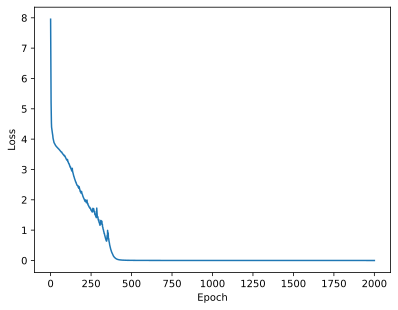

In [ ]:
print(val_losses_log)
plt.plot(val_losses_log)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

In [ ]:
num_params = sum([np.prod(param.shape) for param in model.parameters()])
print("Number of parameters: {:,}".format(num_params))

Number of parameters: 852,160


Seed set to 1


  0%|          | 0/28 [00:00<?, ?it/s]

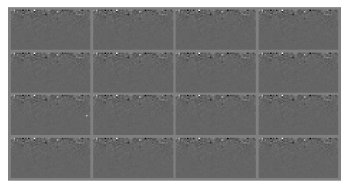

In [ ]:
pl.seed_everything(1)
samples = model.sample(img_shape=(16,1,28,56))
show_imgs(samples.cpu())

0 0


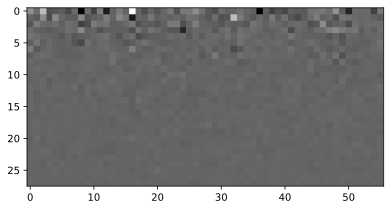

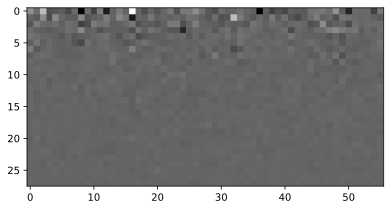

[[ 9075.51219512  6932.68292683 11911.6097561  ...  6680.58536585
   4096.58536585  7436.87804878]
 [ 6302.43902439  5546.14634146  8634.34146341 ...  6617.56097561
   6113.36585366  5609.17073171]
 [ 5483.12195122  7752.          6743.6097561  ...  6743.6097561
   6743.6097561   6806.63414634]
 ...
 [ 6302.43902439  6302.43902439  6239.41463415 ...  6365.46341463
   6365.46341463  6302.43902439]
 [ 6365.46341463  6365.46341463  6302.43902439 ...  6428.48780488
   6239.41463415  6302.43902439]
 [ 6428.48780488  6302.43902439  6365.46341463 ...  6302.43902439
   6428.48780488  6302.43902439]]


Text(0.5, 1.0, 'original image(restored from original DFT)')

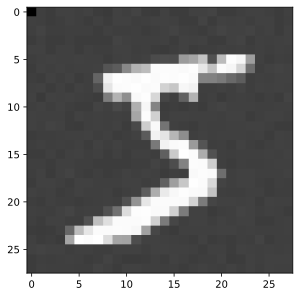

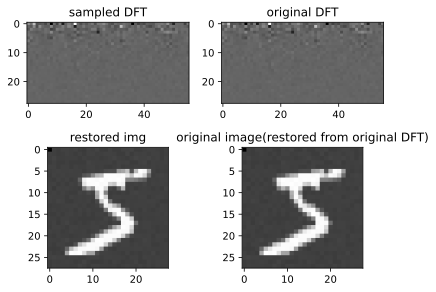

In [ ]:
print(max_log, min_log)
dft = samples[15][0].numpy()*(27526+18065)/255 - 18065
restored_img = inverse_DFT_transform(dft)
plt.imshow(dft, cmap='gray')
plt.show()
plt.imshow(train_set[0][0][0].numpy(), cmap='gray')
plt.show()
plt.imshow(inverse_DFT_transform(train_set[0][0][0].numpy()*(27526+18065)/255 - 18065), cmap= 'gray')
print(samples[0][0].numpy()*7752/123)

fig, axs = plt.subplots(2, 2)
axs[0, 0].imshow(dft, cmap='gray')
axs[0, 0].set_title('sampled DFT')
axs[0, 1].imshow(train_set[0][0][0].numpy(), cmap='gray')
axs[0, 1].set_title('original DFT')
axs[1, 0].imshow(restored_img, cmap='gray')
axs[1, 0].set_title('restored img')
axs[1, 1].imshow(inverse_DFT_transform(train_set[0][0][0].numpy()*(27526+18065)/255 - 18065), cmap='gray')
axs[1, 1].set_title('original image(restored from original DFT)')

In [ ]:
def autocomplete_image(img):
    # Remove lower half of the image
    img_init = img.clone()
    img_init[:,10:,:] = -1
    print("Original image and input image to sampling:")
    show_imgs([img,img_init])
    # Generate 12 example completions
    img_init = img_init.unsqueeze(dim=0).expand(12,-1,-1,-1).to(device)
    pl.seed_everything(1)
    img_generated = model.sample(img_init.shape, img_init)
    print("Autocompletion samples:")
    show_imgs(img_generated)